# 3.4 Stacking and interpolating data

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#3.4-Stacking-and-interpolating-data" data-toc-modified-id="3.4-Stacking-and-interpolating-data-1">3.4 Stacking and interpolating data</a></span><ul class="toc-item"><li><span><a href="#3.4.1-Introduction" data-toc-modified-id="3.4.1-Introduction-1.1">3.4.1 Introduction</a></span><ul class="toc-item"><li><span><a href="#3.4.1.1-Test-your-login" data-toc-modified-id="3.4.1.1-Test-your-login-1.1.1">3.4.1.1 Test your login</a></span></li></ul></li><li><span><a href="#3.4.2-QA-data" data-toc-modified-id="3.4.2-QA-data-1.2">3.4.2 QA data</a></span><ul class="toc-item"><li><span><a href="#3.4.2.1-Why-QA-data?" data-toc-modified-id="3.4.2.1-Why-QA-data?-1.2.1">3.4.2.1 Why QA data?</a></span></li><li><span><a href="#3.4.2.2-Deriving-a-weight-from-QA" data-toc-modified-id="3.4.2.2-Deriving-a-weight-from-QA-1.2.2">3.4.2.2 Deriving a weight from QA</a></span></li><li><span><a href="#3.4.2.3-Extracting-relevant-bit-fields" data-toc-modified-id="3.4.2.3-Extracting-relevant-bit-fields-1.2.3">3.4.2.3 Extracting relevant bit fields</a></span></li></ul></li><li><span><a href="#3.4.2-A-time-series" data-toc-modified-id="3.4.2-A-time-series-1.3">3.4.2 A time series</a></span></li><li><span><a href="#Weighted-interepolation" data-toc-modified-id="Weighted-interepolation-1.4">Weighted interepolation</a></span><ul class="toc-item"><li><span><a href="#Smoothing" data-toc-modified-id="Smoothing-1.4.1">Smoothing</a></span></li><li><span><a href="#weighted-smoothing" data-toc-modified-id="weighted-smoothing-1.4.2">weighted smoothing</a></span></li></ul></li><li><span><a href="#Making-movies" data-toc-modified-id="Making-movies-1.5">Making movies</a></span><ul class="toc-item"><li><span><a href="#Javascript-HTML" data-toc-modified-id="Javascript-HTML-1.5.1">Javascript HTML</a></span></li><li><span><a href="#Animated-gif" data-toc-modified-id="Animated-gif-1.5.2">Animated gif</a></span></li></ul></li></ul></li></ul></div>

[[up to 3.0](Chapter3_1_GDAL.ipynb)]


## 3.4.1 Introduction

In this section, we will:

* develop code to produce a stacked dataset of spatio-temporal data on a grid
* interpolate over any missing data
* smooth the dataset

### 3.4.1.1 Test your login

Let's first test your NASA login:

In [1]:
import geog0111.nasa_requests as nasa_requests
from geog0111.cylog import cylog

url = 'https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2018.09.30/' 
        
# grab the HTML information
try:
    html = nasa_requests.get(url).text
    # test a few lines of the html
    if html[:20] == '<!DOCTYPE HTML PUBLI':
        print('this seems to be ok ... ')
        print('use cylog().login() anywhere you need to specify the tuple (username,password)')
except:
    print('login error ... ')
    print('try entering your username password again')
    print('then re-run this cell until it works')
    print('If its wednesday, ignore this!')
    # uncomment next line to reset password
    #cylog(init=True)

login error ... 
try entering your username password again
then re-run this cell until it works


In [2]:
from geog0111.geog_data import *

destination_folder = Path('data')
if not destination_folder.exists():
        dest_path.mkdir()

# we have the filenames provided 
# in data/lai_filelist_2016.dat.txt
for year in [2016,2017]:
    control_file = f'data/lai_filelist_{year}.dat.txt'
    # read the ascii data from the file in
    filenames = open(control_file).read().split()

    # get the local files
    # set verbose=True if you want to see what is happening
    done = [procure_dataset(f,\
                verbose=False,\
                destination_folder=destination_folder) 
                                    for f in filenames]
    # done should be all True if this has worked

    # print the first 8 in the list, just to see it looks ok
    print(f'\n {year}\n','*'*len(str(year)))
    for f in filenames[:8]:
        print (f)



 2016
 ****
MCD15A3H.A2016001.h17v03.006.2016007075833.hdf
MCD15A3H.A2016001.h17v04.006.2016007074809.hdf
MCD15A3H.A2016001.h18v03.006.2016007073724.hdf
MCD15A3H.A2016001.h18v04.006.2016007073726.hdf
MCD15A3H.A2016005.h17v03.006.2016013012017.hdf
MCD15A3H.A2016005.h17v04.006.2016013011406.hdf
MCD15A3H.A2016005.h18v03.006.2016013012348.hdf
MCD15A3H.A2016005.h18v04.006.2016013012025.hdf

 2017
 ****
MCD15A3H.A2017001.h17v03.006.2017014005341.hdf
MCD15A3H.A2017001.h17v04.006.2017014005344.hdf
MCD15A3H.A2017001.h18v03.006.2017014005401.hdf
MCD15A3H.A2017001.h18v04.006.2017014005359.hdf
MCD15A3H.A2017005.h17v03.006.2017017141758.hdf
MCD15A3H.A2017005.h17v04.006.2017017141805.hdf
MCD15A3H.A2017005.h18v03.006.2017017141813.hdf
MCD15A3H.A2017005.h18v04.006.2017017141824.hdf


Now make sure you have the world borders ESRI shape file you need:

In [3]:
import requests
import shutil 
from pathlib import Path

# zip file
zipfile = 'TM_WORLD_BORDERS-0.3.zip'
# URL
tm_borders_url = f"http://thematicmapping.org/downloads/{zipfile}"
# destibnation folder
destination_folder = Path('data')

# set up some filenames
zip_file = destination_folder.joinpath(zipfile)
shape_file = zip_file.with_name(zipfile.replace('zip','shp'))

# download zip if need to
if not Path(zip_file).exists():
    r = requests.get(tm_borders_url)
    with open(zip_file, 'wb') as fp:
        fp.write (r.content)

# extract shp from zip if need to
if not Path(shape_file).exists():
    shutil.unpack_archive(zip_file.as_posix(),
                         extract_dir=destination_folder)

## 3.4.2 QA data


### 3.4.2.1 Why QA data?

The quality of data varies according to sampling and other factors. For satellite-derived data using optical wavelengths, the two main controls are orbital constraints and cloud cover. We generally define a 'quaity' data layer to express this.

To use a satellite-derived dataset, we need to look at 'quality' data for dataset (and/or uncertainty).

For example, if interpolating data, we would want to base the weight we put on any sample on the 'quality' of that sample. This will be expressed by either some QC (Quality Control) assessment ('good', 'ok', 'bad') or some measure of uncertainty (or both).

Here, we will use the QA information in the LAI product to generate a sample weighting scheme. We shall later use this weighting for data smoothing and interpolation.

First, let's access the LAI and QA datasets.

We can do this by specifying either `Lai_500m` or `FparLai_QC` in the dataset label.

Let's set up the variables we will use, including a pattern to match the `tile` information we need.

Here, we have:

    tile = 'h1[7-8]v0[3-4]'
    
which we can interpret as:

    h17v03, h17v04, h18v03, or h18v04
    
The tile definition ius useful for us to use in any output names (so we can identify it from the name). But the string `h1[7-8]v0[3-4]` contains some 'awkward' characters, namely `[`, `]` and `-` that we might prefer not to use in a filename.

So we derive a new descriptor that we call `tile_` which is more 'filename friendly'.

Thye rest of the code below proceeds much the same as code we have previously used.

We build a gdal VRT file from the set of hdf files using `gdal.BuildVRT()`.

Then we crop to the vector defined by the `FIPS` variable in the shapefile (the country code here) using `gdal.Warp()`. We save this as a gdal VRT file, decsribed by the variable `clipped_file`.

When we make gdal calls, we need to force the system to write files to disc. This can be done by closing the (effective) file descriptors, or by deleting the variable `g` in this case. If you don't do that, you can hit file synchronisation problems. You should always close (or delete) file descriptors when you have finished with them.

You should be able to follow what goes on in the code block below. We will re-use these same ideas later, so it is worthwhile understanding the steps we go through now.

In [4]:
import gdal
import numpy as np
from pathlib import Path
from geog0111.create_blank_file import create_blank_file
from datetime import datetime

#-----------------
# set up the dataset information
destination_folder = Path('data')
year = 2017
product = 'MCD15A3H'
version = 6
tile = 'h1[7-8]v0[3-4]'
doy = 149
params =  ['Lai_500m', 'FparLai_QC']
# Luxembourg
FIPS = "LU"
#-----------------

# make a text-friendly version of tile
tile_ = tile.replace('[','_').replace(']','_').replace('-','')+FIPS

# location of the shapefile
shape_file = destination_folder.\
                 joinpath('TM_WORLD_BORDERS-0.3.shp').as_posix()

# define strings for the ip and op files
ipfile = destination_folder.\
                joinpath(f'{product}.A{year}{doy:03d}.{tile_}.{version:03d}').as_posix()

opfile = ipfile.replace(f'{doy:03d}.','').replace(tile,tile_)

print('ipfile',ipfile)
print('opfile',opfile)

# now glob the hdf files matching the pattern
filenames = list(destination_folder\
                .glob(f'{product}.A{year}{doy:03d}.{tile}.{version:03d}.*.hdf'))

# start with an empty list
ofiles = []

# loop over each parameter we need
for d in params:
    
    # mangle the dataset names
    dataset_names = sorted([f'HDF4_EOS:EOS_GRID:'+\
                         f'"{file_name.as_posix()}":'+\
                         f'MOD_Grid_MCD15A3H:{d}'\
                            for file_name in filenames])

    # derive some filenames for vrt files
    spatial_file = f'{opfile}.{doy:03d}.{d}.vrt'
    clipped_file = f'{opfile}.{doy:03d}_clip.{d}.vrt'
    
    # build the files
    g = gdal.BuildVRT(spatial_file, dataset_names)
    if(g):
        del(g)
        g = gdal.Warp(clipped_file,\
                                   spatial_file,\
                                   format='VRT', dstNodata=255,\
                                   cutlineDSName=shape_file,\
                                   cutlineWhere=f"FIPS='{FIPS}'",\
                                   cropToCutline=True)
        if (g):
            del(g)
        ofiles.append(clipped_file)
print(ofiles)

ipfile data/MCD15A3H.A2017149.h1_78_v0_34_LU.006
opfile data/MCD15A3H.A2017h1_78_v0_34_LU.006
['data/MCD15A3H.A2017h1_78_v0_34_LU.006.149_clip.Lai_500m.vrt', 'data/MCD15A3H.A2017h1_78_v0_34_LU.006.149_clip.FparLai_QC.vrt']


**Exercise 3.4.1**

* examine the code block above, and write a function that takes as inputs the variables given in the block enclosed by `#-----------------`, the dataset information
* the code should setup the VRT files and return the list of clipped dataset filenames: `['data/MCD15A3H.A2017h1_78_v0_34_LU.006.149_clip.Lai_500m.vrt', 'data/MCD15A3H.A2017h1_78_v0_34_LU.006.149_clip.FparLai_QC.vrt']` here.
* Make sure you test your function: check that it generates the files you expect from the inputs you give.
* try to develop an automated test to see that it has worked (Homework)

**Hint**

Be clear about what you are doing in your code.

The purpose of this function is to build clipped VRT files for the conditions you set.

The conditions are the parameters driving the function.

The list of files you develop are returned. 

In [5]:
# do exercise here

### 3.4.2.2 Deriving a weight from QA

We now have some example files describing the LAI and QC datasets:

    data/MCD15A3H.A2017h1_78_v0_34_LU.006.149_clip.Lai_500m.vrt
    data/MCD15A3H.A2017h1_78_v0_34_LU.006.149_clip.FparLai_QC.vrt
    
What we want to develop here is a translation from the QA information (given in `FparLai_QC`) to a *weight* that we can apply to the data. 

If the quality is poor, we want a low weight. If the quality is good, a high weight. It makes sense to call the highest weight 1.0.

The LAI dataset is decribed [on the NASA page](https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mcd15a3h_v006), with the bit field information given in the [file spec](https://ladsweb.modaps.eosdis.nasa.gov/filespec/MODIS/6/MCD15A3H)

         BITFIELDS
       -------------
        0,0  MODLAND_QC bits
             '0' =  Good Quality (main algorithm with or without saturation)
             '1' =  Other Quality (back-up algorithm or fill values)

        1,1 SENSOR
             '0' = Terra
             '1' = Aqua

        2,2  DEADDETECTOR
             '0' = Detectors apparently fine for up to 50% of channels 1,2
             '1' = Dead detectors caused >50% adjacent detector retrieval

        3,4  CLOUDSTATE (this inherited from Aggregate_QC bits {0,1} cloud state)
             '00' = 0 Significant clouds NOT present (clear)
             '01' = 1 Significant clouds WERE present
             '10' = 2 Mixed cloud present on pixel
             '11' = 3 Cloud state not defined,assumed clear

        5,7  SCF_QC (3-bit, (range '000'..100') 5 level Confidence Quality score.
             '000' = 0, Main (RT) method used, best result possible (no saturation)
             '001' = 1, Main (RT) method used with saturation. Good,very usable
             '010' = 2, Main (RT) method failed due to bad geometry, empirical algorithm used
             '011' = 3, Main (RT) method failed due to problems other than geometry, 
                                  empirical algorithm used
             '100' = 4, Pixel not produced at all, value coudn't be retrieved 
                        (possible reasons: bad L1B data, unusable MOD09GA data)

For LAI, we can use the QA information contained in bits 5-7 of `FparLai_QC` to achieve this. 

The valid codes for `SCF_QC` here are:

    0 : Main (RT) method used best result possible (no saturation)
    1 : Main (RT) method used with saturation. Good very usable
    2 : Main (RT) method failed due to bad geometry empirical algorithm used
    3 : Main (RT) method failed due to problems other than geometry empirical algorithm used
    
    
where we have translated the binary representations above to decimal.

A useful way of this to some weight is to define a real number $n$, where $0 <= n < 1$ and raise this to the power of `SCF_QC`.

So, for example is we set `n = 0.61803398875` (the [inverse golden ratio](https://en.wikipedia.org/wiki/Golden_ratio)):

In [6]:
n = 0.61803398875

for SCF_QC in [0,1,2,3]:
    weight = n**SCF_QC
    print(f'SCF_QC: {SCF_QC} => weight {weight:.4f}')


SCF_QC: 0 => weight 1.0000
SCF_QC: 1 => weight 0.6180
SCF_QC: 2 => weight 0.3820
SCF_QC: 3 => weight 0.2361


Then we have the following meaning for the weights:


    1.0000 : Main (RT) method used best result possible (no saturation)
    0.6180 : Main (RT) method used with saturation. Good very usable
    0.3820 : Main (RT) method failed due to bad geometry empirical algorithm used
    0.2361 : Main (RT) method failed due to problems other than geometry empirical algorithm used
    
  
Altghough we could vary the value of $n$ used and get subtle variations, this sort of weighting should produce the desired result.


**Exercise 3.4.2**

* write a function that converts from `SCF_QC` value to weight. 
* Use the given value of $n$ as default, by let it be changed using a keyword.
* make sure any value outside the integer range 0 to 3 inclusive returns a weight of 0.0
* try to make your function operate on arrays.
* show some tests of your function.

**Hint**

Since only `[0,1,2,3]` are valid inputs, you could use conditions such as:

    (SCF_QC == i) * (n ** i)

for valid values of `i`. This should then work correctly for arrays.

In [7]:
# do exercise here

### 3.4.2.3 Extracting relevant bit fields

We still have the task of getting `SFC_QC` by extracting bits 5-7 from the QA dataset.

Let's be clear what we mean by this.

The dataset `FparLai_QC` is of data type `uint8`, unsigned 8-bit integer (i.e. unsigned byte). 

In [8]:
import gdal

# read our example data in
ofiles = ['data/MCD15A3H.A2017h1_78_v0_34_LU.006.149_clip.Lai_500m.vrt', \
          'data/MCD15A3H.A2017h1_78_v0_34_LU.006.149_clip.FparLai_QC.vrt']
params = ['Lai_500m', 'FparLai_QC']
lai = [gdal.Open(ofiles[i]).ReadAsArray() for i in range(len(params))]

FparLai_QC = lai[1]

# print some information
print(FparLai_QC.dtype)
print('2^8 =',2**8)

uint8
2^8 = 256


If all 8 bits are set to 1, it is equal to 255 in decimal. 

In Python, we can write a number in binary (base 2) repersentation by starting it with `0b`:

In [9]:
x = 0b11111111

print(int(x))

255


This is because the bits `11111111` are interpreted as:

    1 x 2^0 +
    1 x 2^1 +
    1 x 2^2 +
    1 x 2^3 +
    1 x 2^4 +
    1 x 2^5 +
    1 x 2^6 +
    1 x 2^7 
    
reading the bit fields from back to front.

This is the same as:

    1 x 1 +
    1 x 2 +
    1 x 4 +
    1 x 8 + 
    1 x 16 +
    1 x 32 +
    1 x 64 +
    1 X 128 = 255
    
Taking an example of a shorted bit field, how then do we interpret `0b1011`?

This is:

    1 x 2^0 +
    1 x 2^1 +
    0 x 2^2 +
    1 x 2^3 
    
(reading back to front), so:

    1 x 1 +
    1 x 2 +
    0 x 4 +
    1 x 8 = 11 

In [10]:
x = 0b1011

print(int(x))

11


explain bit shift and bitwise and mask &

In [11]:
import matplotlib.pylab as plt

ofiles = ['data/MCD15A3H.A2017h1_78_v0_34_LU.006.149_clip.Lai_500m.vrt', \
          'data/MCD15A3H.A2017h1_78_v0_34_LU.006.149_clip.FparLai_QC.vrt']
params = ['Lai_500m', 'FparLai_QC']
lai = [gdal.Open(ofiles[i]).ReadAsArray() for i in range(len(params))]


lai[0] = lai[0] * 0.1
# if we want bit field 5-7
# we form a binary mask
mask57 = 0b11100000
# and right shift 5 (>> 5)
lai[1] = (lai[1] & mask57) >> 5
# 0 to 3 are good
scale = 0.61803398875
lai[1] = (scale**0) * (lai[1] == 0).astype(float) + \
         (scale**1) * (lai[1] == 1).astype(float) + \
         (scale**2) * (lai[1] == 2).astype(float) + \
         (scale**3) * (lai[1] == 3).astype(float)
    

    
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True,
                       figsize=(10,5))
axs = np.array(axs).T.flatten()

for i in range(len(params)):
    img = axs[i].imshow(lai[i], interpolation="nearest",
                 cmap=plt.cm.inferno_r)
    axs[i].set_title(params[i])
    plt.colorbar(img,ax=axs[i],shrink=0.7)

## 3.4.2 A time series

You should now know how to access and download datasets from the NASA servers and have developed functions to do this.

You should also know how to select a dataset from a set of hdf files, and mosaic, mask and crop the data to correspond to some vector boundary. This is a very common task in geospatial processing.

We now consider the case where we want to analyse a time series of data. We will use LAI over time to exemplify this.



In [12]:
import gdal
import numpy as np
from pathlib import Path
from geog0111.create_blank_file import create_blank_file
from datetime import datetime

destination_folder = Path('data')
year = 2017
product = 'MCD15A3H'
version = 6
tile = 'h1[7-8]v0[3-4]'
params =  ['Lai_500m', 'FparLai_QC']
# time step
dt = 4


tile_ = tile.replace('[','_').replace(']','_').replace('-','')+FIPS

shape_file = destination_folder.\
                 joinpath('TM_WORLD_BORDERS-0.3.shp').as_posix()

allopfile = destination_folder.\
                joinpath(f'{product}.A{year}.{tile_}.{version:03d}')

ndays_in_year = (datetime(year,12,31) - datetime(year,1,1)).days + 1


for d in params:
    old_clip = None
    allvrt = []
    bandNames = []
    for doy in range(1,ndays_in_year+1,dt):

        ipfile = destination_folder.\
                    joinpath(f'{product}.A{year}{doy:03d}.{tile_}.{version:03d}').as_posix()

        opfile = ipfile.replace(f'{doy:03d}.','').replace(tile,tile_)

        filenames = destination_folder\
                    .glob(f'{product}.A{year}{doy:03d}.{tile}.{version:03d}.*.hdf')

        dataset_names = sorted([f'HDF4_EOS:EOS_GRID:'+\
                             f'"{file_name.as_posix()}":'+\
                             f'MOD_Grid_MCD15A3H:{d}'\
                                for file_name in filenames])
        spatial_file = f'{opfile}.{doy:03d}.{d}.vrt'
        clipped_file = f'{opfile}.{doy:03d}_clip.{d}.vrt'
        if len(dataset_names):
            g = gdal.BuildVRT(spatial_file, dataset_names)
            if(g):
                del(g)
                g = gdal.Warp(clipped_file,\
                                   spatial_file,\
                                   format='VRT', dstNodata=255,\
                                   cutlineDSName=shape_file,\
                                   cutlineWhere=f"FIPS='{FIPS}'",\
                                   cropToCutline=True)
        elif old_clip:
            blank_file_tiff = f'{opfile}_blank.tiff'
            # generate a blank dataset in case of missing days
            if not Path(blank_file_tiff).exists():
                # copy info
                create_blank_file(old_clip,blank_file_tiff,value=255)

            # build a vrt
            g = gdal.BuildVRT(clipped_file, [blank_file_tiff])

        if (g):
            del(g)
            bandNames.append(f'DOY {doy:03d}')
            allvrt.append(clipped_file)

        old_clip = clipped_file



    g = gdal.BuildVRT(f'{allopfile.as_posix()}.{d}.vrt', allvrt,\
                      options=gdal.BuildVRTOptions(VRTNodata=255,\
                                                   srcNodata=255,\
                                                   allowProjectionDifference=True,\
                                                   separate=True))
    if (g):
        # set band names
        for i in range(g.RasterCount):
            g.GetRasterBand(i+1).SetDescription(bandNames[i])

        # close and flush file
        del g
        print (f'{allopfile.as_posix()}.{d}.vrt')

data/MCD15A3H.A2017.h1_78_v0_34_LU.006.Lai_500m.vrt
data/MCD15A3H.A2017.h1_78_v0_34_LU.006.FparLai_QC.vrt


In [13]:
import gdal
import numpy as np

destination_folder = Path('data')
year = 2017
product = 'MCD15A3H'
version = 6
tile = 'h1[7-8]v0[3-4]'
params =  ['Lai_500m', 'FparLai_QC']
FIPS = 'LU'

tile_ = tile.replace('[','_').replace(']','_').replace('-','')+FIPS
allopfile = destination_folder.\
                joinpath(f'{product}.A{year}.{tile_}.{version:03d}')


lai = []
for d in params:
    
    g = gdal.Open(f'{allopfile.as_posix()}.{d}.vrt',gdal.GA_ReadOnly)
    data = np.array([g.GetRasterBand(b+1).ReadAsArray() \
                for b in range(g.RasterCount)])

    lai.append(data)

lai[0] = lai[0] * 0.1
# if we want bit field 5-7
# we form a binary mask
mask57 = 0b11100000
# and right shift 5 (>> 5)
lai[1] = (lai[1] & mask57) >> 5
# 0 to 3 are good
scale = 0.61803398875
lai[1] = (scale**0) * (lai[1] == 0).astype(float) + \
         (scale**1) * (lai[1] == 1).astype(float) + \
         (scale**2) * (lai[1] == 2).astype(float) + \
         (scale**3) * (lai[1] == 3).astype(float)
    
print(lai[0].shape)

(92, 176, 123)


## Weighted interepolation

### Smoothing

There are many approaches to weighted interpolation. One such is to use a convolution smoothing operation.

In convolution, we combine a *signal* $y$ with a *filter* $f$ to achieve a filtered signal. For example, if we have an noisy signal, we will attempt to reduce the influence of high frequency information in the signal (a 'low pass' filter, as we let the low frequency information *pass*).

In this approach, we define a digital filter (convolution filter) that should be some sort of weighted average function. A typical filter is the Gaussian, defined by the parameter $\sigma$. The larger the value of $\sigma$, the 'wider' the filter, which means that the weighted average will be takjen over a greater extent.

We do not expect you to be overly concerned with the code in these sections below, as the main effort should be directed at understanding smoothing and interpolation at this point.

Let's look at this filter:

A digital (discrete) convolution uses a sampled signal and filter (represented on a grid).

Without going into the maths, the convolution operates by running the filter centred on $x_c$ over the extent of the signal as illustrated below.

*At each value of $x_c$*, the filter is **multiplied by the signal**. Clearly, where the filter is zero, the influence of the signal is zero. So, the filter effectively selects a local window of data points (shown as green crosses below). The result, i.e. the filtered signal, is simply the weighted average of these local samples. This can be seen in the lower panel, where the green dot shows the filtered signal at $x_c$.

The convolution of a low pass ('smoothing') filter with a signal results in a smoothing of the signal:

The degree of smoothing is greater, the larger the value of $\sigma$ (i.e. the broader the convolution filter). Eventually, the signal would go 'flat', i.e. be a constant (weighted mean) value, if we used a very broad filter.

For small values of $\sigma$ though, the signal is still rather noisy. 

There is a trade-off then between noise suppression and the degree of generalisation.

We could define some concept of an 'optimium' value of $\sigma$, for example using [cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)). But often we can decide empirically an appropriate filter width.

We perform the convolution using:

    convolve1d(y, filter,mode='wrap')
    
from the `scipy.ndimage.filters` library.

The first argument is the signal to be filtered. The second is the filter (the Gaussian here). 

We set 

    mode='wrap'
    
which defines the boundary conditions to be periodic ('wrapped around'). This would generally be appropriate for time series e.g. of one year.

### weighted smoothing

In the convolution examples above, we apply the smoothing equally to all samples of the signal.


What if we knew that some samples were 'better' (quality) than others? What if some samples were missing? How could we incorporate this information?

The answer is to *weight* the convolution.

For each sample point in the signal, we define a *weight*, where the weight is high if we trust the data point and low if we don't trust it much. We apply a weight of zero if a data point is missing.

Then, the weighted convolution is simply the result of applying the filter to (weight $\times$ signal), divided by the result of applying the filter to the weight alone. You can think of the denominator here as a form of 're-normalisation' of the filter.

We illustrate this by removing samples from the example above, and giving a weight of zero for the 'missing' observations.

The result is not as good as we got above, but that is hardly surprising: we are interpolating here and it is hard to interpolate over large gaps.

Since the gaps are quite large, we might benefit from using a larger filter extent. This is then liable to degrade the quality somewhat (over smooth) in data rich areas. These are typical trade-offs we must balance.


In [20]:
weight = lai[1]
sigma = 8
import scipy

x = np.arange(-3*sigma,3*sigma+1)
gaussian = np.exp((-(x/sigma)**2)/2.0)

x = scipy.ndimage.filters.convolve1d(lai[0] * weight, gaussian, axis=0,mode='wrap')
w = scipy.ndimage.filters.convolve1d(weight, gaussian, axis=0,mode='wrap')

# avoid divide by 0 problems by setting zero values
# of the denominator to not a number (NaN)
w[w==0] = np.nan

# 
ilai = x/w

(0, 6)

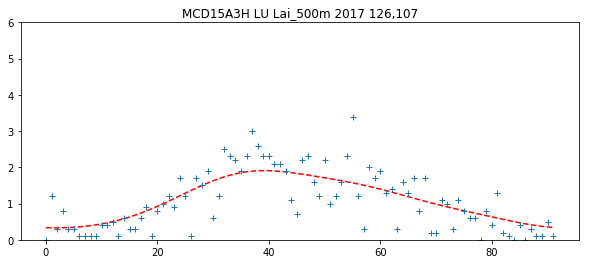

In [21]:
## find where the weight is highest, and lets look there!
sweight = weight.sum(axis=0)
r,c = np.where(sweight == np.max(sweight))
plt.figure(figsize=(10,4))
plt.title(f'{product} {FIPS} {params[0]} {year} {r[0]},{c[0]}')
plt.plot((ilai)[:,r[0],c[0]],'r--')
plt.plot((lai[0])[:,r[0],c[0]],'+')
plt.ylim(0,6)

## Making movies

It is often useful to animate time series information. There are several ways of doing this.

Bear in mind that the larger the datasets, number of images and/or frames, the more time it is likely to take to generate the animations. You probably don't want more than around 100 frames to make an animation of this sort.

The two approaches we will use are:

* Javascript HTML in the notebook using `anim.to_jshtml()` from `matplotlib.animation`
* Animated gif using the `imageio` library

### Javascript HTML

This approach uses javascript in html within the notebook to genrate an animation and player. The player is useful, in that we can easily stop at and explore individual frames.

The HTML representation is written to a temporary directory (internally to [anim.to_jshtml()](https://matplotlib.org/_modules/matplotlib/animation.html#Animation.to_jshtml)) but deleted on exit.

### Animated gif

In the second approach, we save individual frames of an animation, and read them in, using `imageio.imread()` into a list. We choose to write the individual frames here to a temporary directory (so they are cleaned up on exit).

This list of `imageio` datasets is then fed to [`imageio.mimsave()`](https://imageio.readthedocs.io/en/stable/userapi.html) to save the sequence as an animated gif. This can then be displayed in a notebook cell (or otherwise). Note that the file [data/MCD15A3H.A2017.h1_78_v0_34_LU.006.gif](data/MCD15A3H.A2017.h1_78_v0_34_LU.006.gif) is saved in this case.

In [23]:
import imageio
import tempfile
from pathlib import Path

'''
lai movie as animated gif
'''

# switch interactive plotting off
# as we just want to save trhe frames, 
# not plot them now
plt.ioff()

image_folder = Path('images')

allopfile = image_folder.\
                joinpath(f'{product}.A{year}.{tile_}.{version:03d}')

images = []
with tempfile.TemporaryDirectory() as tmpdirname:
    ofile = f'{tmpdirname}/tmp.png'
    
    for i in range(ilai.shape[0]):
        plt.figure(0,figsize=(10,10))
        # don' display the interim frames
        plt.ioff()
        plt.clf()
        plt.imshow(ilai[i],vmin=0,vmax=6,cmap=plt.cm.inferno_r)
        plt.title(f'{product} {FIPS} {params[0]} {year} DOY {dt*i+1:03d}')
        plt.colorbar(shrink=0.85)
        plt.savefig(ofile)    
        images.append(imageio.imread(ofile))
plt.clf()
imageio.mimsave(f'{allopfile}.gif', images)
print(f'{allopfile}.gif')
# switch interactive plotting back on
plt.ion()

images/MCD15A3H.A2017.h1_78_v0_34_LU.006.gif


<Figure size 720x720 with 0 Axes>

![](images/MCD15A3H.A2017.h1_78_v0_34_LU.006.gif)